In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import f1_score, make_scorer, roc_curve
import random

In [2]:
class featureMatrix(object):
    def __init__(self, mat, samples, features):
        self.mat = mat
        self.samples = np.array(samples)
        self.features = features
        
    def getMat(self):
        return(self.mat)
    
    def getSamples(self):
        return(self.samples)
    
    def getFeatures(self):
        return(self.features)
    
    def filterSamplesByName(self, samplesToInclude):
        include = [(x in samplesToInclude) for x in self.samples]
        self.mat = self.mat[include, :]
        self.samples = self.samples[include]
        
    def nSamples(self):
        return(len(self.samples))
    
    def getSampleSet(self, indices):
        return(featureMatrix(self.mat[indices, :], self.samples[indices,], self.features))

In [3]:
def getPhenotypeData(phenoType = ""):
    use_colnames = ['identifier', 'diagnosis']
    y = pd.read_csv("data/all_samples_filtered_labels.csv", usecols = use_colnames, index_col=0)
    y["diagnosis"] = np.where(y['diagnosis'] == 'Autism', 1, 0)
    return(y)

def getControlIds_Agre_Ssc():
    Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()
    SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()
    X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)
    return(X_ctrl.index.values.tolist())

def getOverlappingSubjects(X, y, ped):
    subjects = list(set(y.index.values.tolist()) & set(X.getSamples())) #Get ids with gene and phenotype info
    
    #Add in ids that are implied controlled based on agre and ssc
    ctrl_ids = getControlIds_Agre_Ssc()
    to_add = set(ctrl_ids) - (set(subjects)) #throw ids that will already be included b/c they have explicit label
    y_ctrl = pd.DataFrame(np.zeros(len(to_add),), columns = ['diagnosis'],index = to_add)
    y = pd.concat([y, y_ctrl], axis = 0)
    subjects = subjects + list(to_add)
    
    #Filter data to include only selected samples
    X.filterSamplesByName(subjects) #include only samples present in provided list
    y = y.filter(items = subjects, axis = 0)
    y = y.reindex(X.getSamples()) #re-order to match gene info
    print("All subjects are equivalent in X and y sets: ", sum(y.index.values.tolist() == X.getSamples()) == X.nSamples())
    
    ped = ped.filter(items = subjects, axis = 0)
    ped = ped.reindex(X.getSamples())
    print("All subjects are equivalent in X and pedigree sets: ", sum(ped.index.values.tolist() == X.getSamples()) == X.nSamples())
    return(X, y, ped)
    
def getPedigree(pedType):
    if pedType == "agre":
        agre_ped = pd.read_csv("data/v34.vcf.ped", 
                sep = "\t", 
                usecols = [0,1])
        agre_ped.columns = ['fid','sibid']
        agre_ped = agre_ped.set_index('sibid')
        return(agre_ped)
        
    if pedType == "ssc":
        # read ssc ped 
        ssc_ped = pd.read_csv("data/ssc.ped", sep = "\t", header = None, usecols = [0,1])
        ssc_ped.columns = ['fid','sibid']
        ssc_ped = ssc_ped.set_index('sibid')
        return(ssc_ped)
       

def concatPedigrees(ped1, ped2):
    ped = pd.concat([ped1, ped2], axis = 0, ignore_index = False) 
    return(ped)
    
    
def getFeatureData(featType):
    
    if(featType == 'agre_ssc'):
        #Returns a np_array, sample list, and features list
        Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
        Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()
        
        SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
        SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()
        
        # merge SSC and Agre data
        X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
        X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

        X = np.concatenate([X_asd, X_ctrl], axis=0)
        samples = X_asd.index.values.tolist() + X_ctrl.index.values.tolist()
        features = X_asd.columns.values.tolist()
        
        X = featureMatrix(featMat, samples, features)
        return(X)
        
        
    if(featType == 'HAR'):
        #Returns a np_array , sample list, and features list, b/c memory constraints
        import os
        matrices = list()
        samples = []
        features = list()
        total = 0
        for file in os.listdir("data_iHart/HAR/"):
            if file.endswith(".npz"):
                file_path = os.path.join("data_iHart/HAR/", file)
                print(file_path)
                chrom = np.load(file_path)
                matrices.append(pd.DataFrame(chrom['binMatrix']))
                samples = [x.decode("ascii") for x in chrom['row_labels']] #Inefficient, but only need one set of sample ids
                features.append( chrom['col_labels'])
                
        featMat = np.concatenate(matrices, axis = 1)
        features_unlist = [feat for chrom_featList in features for feat in chrom_featList]
        
        X = featureMatrix(featMat, samples, features_unlist)
        return(X)
                
        

    
    

In [4]:
X = getFeatureData(featType = "HAR")
y = getPhenotypeData()
ped = concatPedigrees(getPedigree('agre'), getPedigree('ssc'))

data_iHart/HAR/HAR_matrix_1.npz
data_iHart/HAR/HAR_matrix_10.npz
data_iHart/HAR/HAR_matrix_11.npz
data_iHart/HAR/HAR_matrix_12.npz
data_iHart/HAR/HAR_matrix_13.npz
data_iHart/HAR/HAR_matrix_14.npz
data_iHart/HAR/HAR_matrix_15.npz
data_iHart/HAR/HAR_matrix_16.npz
data_iHart/HAR/HAR_matrix_17.npz
data_iHart/HAR/HAR_matrix_18.npz
data_iHart/HAR/HAR_matrix_2.npz
data_iHart/HAR/HAR_matrix_20.npz
data_iHart/HAR/HAR_matrix_21.npz
data_iHart/HAR/HAR_matrix_22.npz
data_iHart/HAR/HAR_matrix_3.npz
data_iHart/HAR/HAR_matrix_4.npz
data_iHart/HAR/HAR_matrix_5.npz
data_iHart/HAR/HAR_matrix_6.npz
data_iHart/HAR/HAR_matrix_7.npz
data_iHart/HAR/HAR_matrix_8.npz
data_iHart/HAR/HAR_matrix_9.npz
data_iHart/HAR/HAR_matrix_X.npz


In [5]:
X, y, ped = getOverlappingSubjects(X, y, ped)

('All subjects are equivalent in X and y sets: ', True)
('All subjects are equivalent in X and pedigree sets: ', True)


In [6]:
print("Number Control : ", sum(y['diagnosis'] == 0))
print("Number Cases: ", sum(y['diagnosis'] == 1))

('Number Control : ', 416)
('Number Cases: ', 2105)


Logistic Regression:
Now that we have gathered all the data we will need, let's split the data into a train and test set, and use k fold cross-validation on the train set to train a LR model and evaluate our results (once they're good) on the test set.

In [7]:
#Split groups into training and test, being careful about siblings from the same family in the same set
group_split = GroupShuffleSplit(test_size=.25, n_splits = 1) #25% test set

In [8]:
famid_strs = [str(x) for x in ped.loc[:, 'fid']]


In [9]:
for train_ind, test_ind in group_split.split(X.getMat(), y, famid_strs):
    train_ind = train_ind
    test_ind = test_ind
    
#Check that no family id's overlap
train_subj = X.getSamples()[train_ind]
test_subj = X.getSamples()[test_ind]
train_fid = [str(x) for x in ped.loc[train_subj, 'fid']]
test_fid = [str(x) for x in ped.loc[test_subj, 'fid']]

print("family ids that appear in both train and test set: ", set(train_fid).intersection(set(test_fid)))

X_train = X.getSampleSet(train_ind)
y_train = y.iloc[train_ind]
X_test = X.getSampleSet(test_ind)
y_test = y.iloc[test_ind]

('family ids that appear in both train and test set: ', set([]))


In [10]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

ImportError: cannot import name reload


Running cross validation for fold 1:
Train Score: 0.845878 Test Score: 0.571292
('AU-ROC', 0.57129220257234736)
('\nOptimum threshold to maximize training accuracy:', 0.64411211055536255)
('F1:', 0.84639498432601867)
('Accuracy:', 0.73866666666666669)
('Confusion Matrix:\n', array([[  7,  57],
       [ 41, 270]]))


/Users/mayavarma/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


('\nOptimum threshold to maximize f1:', 0.64262157162234768)
('F1:', 0.84639498432601867)
('Accuracy:', 0.73866666666666669)
('Confusion Matrix:\n', array([[  7,  57],
       [ 41, 270]]))
None


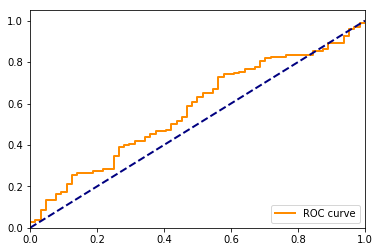


Running cross validation for fold 2:
Train Score: 0.851087 Test Score: 0.517654
('AU-ROC', 0.51765368724176786)
('\nOptimum threshold to maximize training accuracy:', 0.65635318164322409)
('F1:', 0.87405159332321702)
('Accuracy:', 0.77866666666666662)
('Confusion Matrix:\n', array([[  4,  45],
       [ 38, 288]]))
('\nOptimum threshold to maximize f1:', 0.59845950033737894)
('F1:', 0.8918518518518519)
('Accuracy:', 0.80533333333333335)
('Confusion Matrix:\n', array([[  1,  48],
       [ 25, 301]]))
None


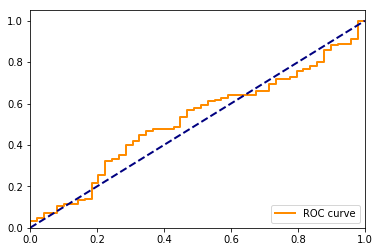


Running cross validation for fold 3:
Train Score: 0.851548 Test Score: 0.547331
('AU-ROC', 0.54733072245697201)
('\nOptimum threshold to maximize training accuracy:', 0.61084749316235964)
('F1:', 0.89088191330343802)
('Accuracy:', 0.80533333333333335)
('Confusion Matrix:\n', array([[  4,  58],
       [ 15, 298]]))
('\nOptimum threshold to maximize f1:', 0.60618788092403297)
('F1:', 0.89088191330343802)
('Accuracy:', 0.80533333333333335)
('Confusion Matrix:\n', array([[  4,  58],
       [ 15, 298]]))
None


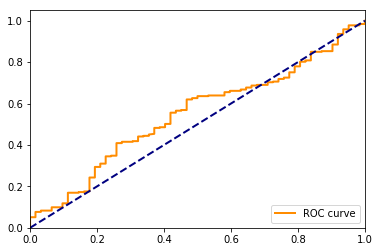


Running cross validation for fold 4:
Train Score: 0.854588 Test Score: 0.536632
('AU-ROC', 0.53663246165728795)
('\nOptimum threshold to maximize training accuracy:', 0.67959685156445948)
('F1:', 0.85358255451713405)
('Accuracy:', 0.7493333333333333)
('Confusion Matrix:\n', array([[  7,  50],
       [ 44, 274]]))
('\nOptimum threshold to maximize f1:', 0.61945981972478226)
('F1:', 0.87234042553191482)
('Accuracy:', 0.77600000000000002)
('Confusion Matrix:\n', array([[  4,  53],
       [ 31, 287]]))
None


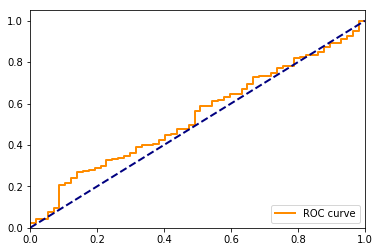


Running cross validation for fold 5:
Train Score: 0.855780 Test Score: 0.576154
('AU-ROC', 0.57615384615384613)
('\nOptimum threshold to maximize training accuracy:', 0.60618920128344733)
('F1:', 0.88048411497730716)
('Accuracy:', 0.78933333333333333)
('Confusion Matrix:\n', array([[  5,  60],
       [ 19, 291]]))
('\nOptimum threshold to maximize f1:', 0.60058633016049034)
('F1:', 0.88084464555052788)
('Accuracy:', 0.78933333333333333)
('Confusion Matrix:\n', array([[  4,  61],
       [ 18, 292]]))
None


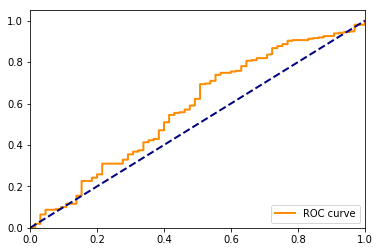

In [11]:
import class_EvalLR
from class_EvalLR import EvalLR
reload(class_EvalLR)

evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1')
scores, topvals = evalr.kfold(5, True)

In [12]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.845878   0.571292
2    0.851087   0.517654
3    0.851548   0.547331
4    0.854588   0.536632
5     0.85578   0.576154
('Train:', 0.85177628361389068)
('Test:', 0.54981258401644428)


In [13]:
# create a plot of preformance versus f1 score for different c values
def reg_plot(c_vals, X_train, y_train, train_fid, resample = False):
    c_scores = []
    print( "Running 7-fold cross validation for:")
    for i in range(len(c_vals)):
        #print "C = %f" % c_vals[i]
        evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1', c = c_vals[i])
        c_scores.append(np.mean(evalr.kfold(7, False, False, resample)[0].Test_score))

    plt.clf()
    plt.ylabel('Feature 2')
    plt.xlabel('Feature 1')
    plt.plot(c_vals, c_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))
    return c_vals[c_scores.index(max(c_scores))]

Running 7-fold cross validation for:


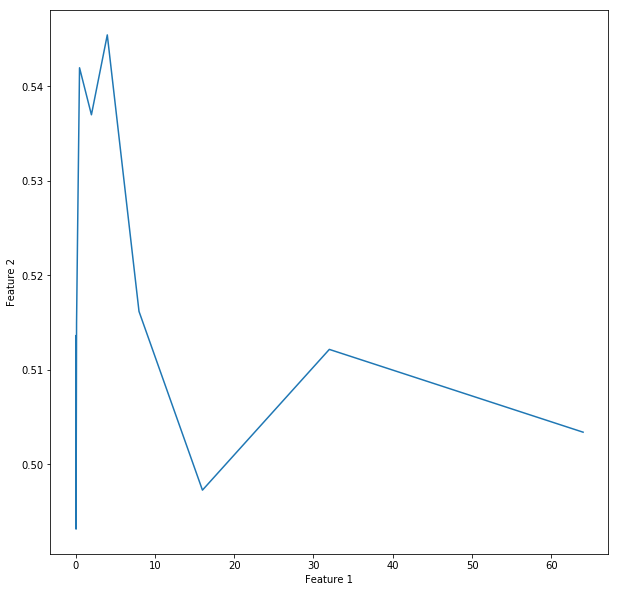

In [14]:
import class_EvalLR
from class_EvalLR import EvalLR
reload(class_EvalLR)
c_vals = [2**6, 2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
c_opt = reg_plot(c_vals, X_train, y_train, train_fid, resample = True)


Running cross validation for fold 1:
Train Score: 1.000000 Test Score: 0.552419
AU-ROC 0.552419354839

Optimum threshold to maximize training accuracy: 0.676890176118
F1: 0.826366559486
Accuracy: 0.714285714286
Confusion Matrix:
 [[ 13  55]
 [ 53 257]]

Optimum threshold to maximize f1: 0.676890176118
F1: 0.826366559486
Accuracy: 0.714285714286
Confusion Matrix:
 [[ 13  55]
 [ 53 257]]
None


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


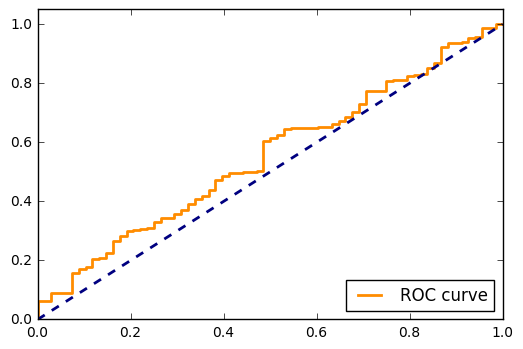


Running cross validation for fold 2:
Train Score: 1.000000 Test Score: 0.494313
AU-ROC 0.494313000912

Optimum threshold to maximize training accuracy: 0.682422089075
F1: 0.775919732441
Accuracy: 0.645502645503
Confusion Matrix:
 [[ 12  55]
 [ 79 232]]

Optimum threshold to maximize f1: 0.682422089075
F1: 0.775919732441
Accuracy: 0.645502645503
Confusion Matrix:
 [[ 12  55]
 [ 79 232]]
None


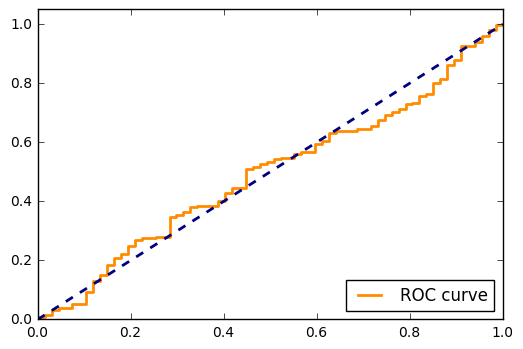


Running cross validation for fold 3:
Train Score: 1.000000 Test Score: 0.550052
AU-ROC 0.550052410901

Optimum threshold to maximize training accuracy: 0.746008288792
F1: 0.808652246256
Accuracy: 0.695767195767
Confusion Matrix:
 [[ 20  40]
 [ 75 243]]

Optimum threshold to maximize f1: 0.746008288792
F1: 0.808652246256
Accuracy: 0.695767195767
Confusion Matrix:
 [[ 20  40]
 [ 75 243]]
None


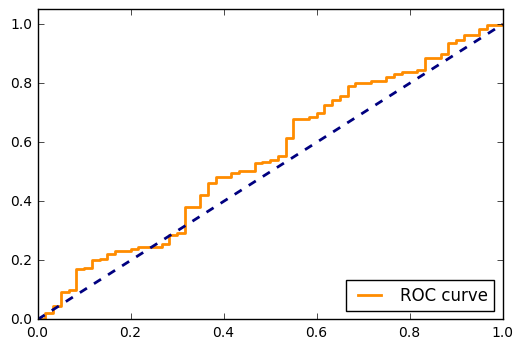


Running cross validation for fold 4:
Train Score: 1.000000 Test Score: 0.512644
AU-ROC 0.51264418811

Optimum threshold to maximize training accuracy: 0.593910465894
F1: 0.818619582665
Accuracy: 0.701058201058
Confusion Matrix:
 [[ 10  46]
 [ 67 255]]

Optimum threshold to maximize f1: 0.593910465894
F1: 0.818619582665
Accuracy: 0.701058201058
Confusion Matrix:
 [[ 10  46]
 [ 67 255]]
None


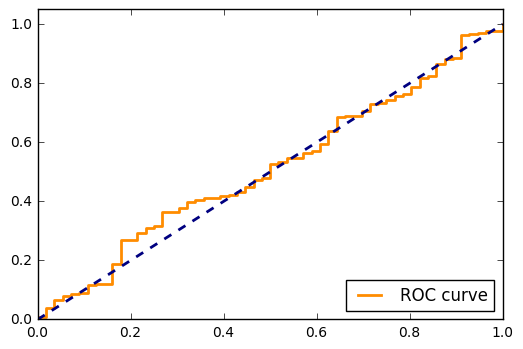


Running cross validation for fold 5:
Train Score: 1.000000 Test Score: 0.572588
AU-ROC 0.572587719298

Optimum threshold to maximize training accuracy: 0.660957136123
F1: 0.818923327896
Accuracy: 0.705570291777
Confusion Matrix:
 [[ 15  42]
 [ 69 251]]

Optimum threshold to maximize f1: 0.660957136123
F1: 0.818923327896
Accuracy: 0.705570291777
Confusion Matrix:
 [[ 15  42]
 [ 69 251]]
None


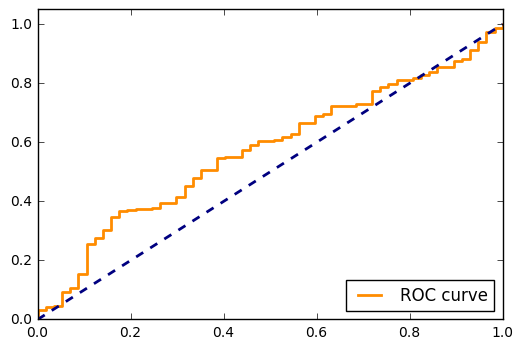

In [19]:
evalr = EvalLR(X_train, y_train, train_fid, reg = 'l1', c = c_opt)
scores, topgenes = evalr.kfold(5, True)

In [20]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1           1   0.552419
2           1   0.494313
3           1   0.550052
4           1   0.512644
5           1   0.572588
Train: 1.0
Test: 0.536403334812


Next step to try will be a combination of coding and non-coding space